### PARALLEL DISTRIBUTED PROCESSING (Hinton) p.334


In [1]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from itertools import product

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(y):
    return y * (1 - y)

In [3]:
class NeuralNetwork:
    
    # Make weight initiation repeatable, so that chance of initializing the weights 
    # closer to the optimum, doesn't affect the performance of the net.
    # Feel free to comment out this line, and you will see in the plot, that the net 
    # will be converging in a  minimun prediction error, faster or slower, each time.
    np.random.seed(0)
    
    def __init__(self, N):
        ######
        # self ; the class object
        # N ; len(data[0]) = 4 , where x the original data array mxN, NOT yet concatenated
        ######
        
        self.activation = sigmoid
        self.activation_derivative = sigmoid_derivative
        self.arch = [N, N, 1]
        self.layers = len(self.arch)
        self.weights = []
        for i in range(2):
            w = 2*np.random.rand(self.arch[i]+1, self.arch[i+1])  -  1
            self.weights.append(w) # [(N+1)xN, (N+1)x1]
            
    def _forward(self, x):
        #####
        # self ; class object
        # x ; the concatenated data array mx(N+1), i.e. [[1 0 0 0 0]
        #                                                [1 0 0 0 1]
        #                                                [1 0 0 1 0]
        #                                                [1 0 0 1 1]
        #                                                ...
        #                                                [1 1 1 1 1]]
        ####
        
        # initialize list of arrays, each array mxN[i], the activations of the layer i. 
        a = []
        
        # 1st layer
        a.append(x) # [array(m,(N+1))]
        
        # hidden layer
        for i in range(len(self.weights)-1): # 0..(1-1) -> 0
            z = np.dot(a[i], self.weights[i]) # m,(N+1) dot (N+1),N = m,N
            a_temp = self.activation(z) # m,N
            a_temp = np.concatenate((np.ones((1, a_temp.shape[0])).T, a_temp), axis=1) # m,1 concat m,N = m,(N+1)
            a.append(a_temp) # [array(m,(N+1)), array(m,(N+1))]
            
        # last layer
        z = np.dot(a[-1], self.weights[-1]) # m,N+1 dot N+1,1 = m,1
        a_temp = self.activation(z) # m,1
        a.append(a_temp)  
        
        return a # [array(m,N+1), array(m,N+1), array(m,1)]
    
    
    def _backprop(self, a, labels, learning_rate=0.1):
        #####
        # self ; class object
        # a ; the list of activation arrays - [array(m,(N+1)), array(m,(N+1)), array(m,1)] -.
        # labels ; the (m,) array with the labels
        # learning_rate ; 0.1
        #####
        
        ## we use the chain rule ; delta_weight = dError/dz * dz/dweight
        # more formally delta_weight[j] = a[j].T.dot(delta_vec[j]), where 
        # delta_vec[j] = dError/dz[j+1], and 
        # delta_vec = delta_vec.reverse()
        
        # initialize the delta_vec ; i.e. the derivatives [ dError/dz[2], dError/dz[1]] 
        delta_vec = []
        
        # last weight ; delta_vec[0] = dError/dz[2]
        error = (labels - a[-1]) # m,1 - m,1 = m,1
        error = error * self.activation_derivative(a[-1]) # m,1 * m,1 = m,1
        delta_vec = [error] # [dError/dz[2]] of shape [(m,1)]
        
        # nextolast up to first weight array ; here there is only delta_vec[1] = dError/dz[1]
        for i in range((self.layers-2), 0, -1): # (3-2)..1 -> 1..1 -> 1
            error = delta_vec[-1].dot(self.weights[i][1:].T) # m,1 dot 1,N = m,N
            error = error * self.activation_derivative(a[i][:,1:]) # m,N * m,N = m,N
            delta_vec.append(error) # [dError/dz[2], dError/dz[1]] = [array(m,1), array(m,N)]
            
        # reverse [dError/dz[2], dError/dz[1]] -> [dError/dz[1], dError/dz[2]]
        delta_vec.reverse() # [(m,N), (m,1)]
        
        # update rule
        for i in range(len(self.weights)):
            layer = a[i] # 1st layer ; m,N+1
                         # 2nd layer ; m,N+1
            delta = delta_vec[i] # 1st layer ; m,N 
                                 # 2nd layer ; m,1
            self.weights[i] += learning_rate * layer.T.dot(delta) # 1st ; N+1,m dot m,N = N+1,N
                                                                  # 2nd ; N+1,m dot m,1 = N+1,1
    
    def _fit(self, original_data, labels, learning_rate=0.1, epochs=3000):
        #####
        # self ; the class object 
        # original_data ; (m,N) array of all possible binary combinations (m = 2^N)
        # labels ; (m,) array
        # epochs ; i have already predefined the epochs to 3000 because that's the min  
        #          number of epochs, the net needs to start to converge.
        # learning_rate ; feel free to play with the learning rate
        ######
        
        # add the bias unit to the input layer for all the examples ; (m,N) -> (m,N+1)
        ones = np.ones((1, original_data.shape[0])) # 1,m
        data = np.concatenate((ones.T, original_data), axis=1) # m,1 concat m,N -> m,N+1
        
        # keep track of prediction error in the plot prediction error, epochs) 
        er = []
        
        # reshape the labels (m,) -> m,1 
        m = labels.shape[0]
        labels = labels.reshape(m, 1)
        
        for epoch in range(epochs):
            
            # create a batch of 100 samples for the epoch. 
            sample = np.random.randint(data.shape[0], size=100) # (1,100) array with int's from 0..15
            
            # forward
            input_ = data[sample]
            a = self._forward(input_)
            
            # backprop
            target = labels[sample]
            self._backprop(a, target, learning_rate=0.2)
            
            # keep track of the error for the plot 
            err = 0
            for i in range(original_data.shape[0]):
                err += np.square(self.predict_single_data(original_data[i]) - labels[i])
            er.append(err)
            
            if epoch % 1000 == 0:
                print ('epoch is {}'.format(epoch))
                print ('prediction error is :', err) 
        
        # plot prediction error vs epoch
        x_axis = [i for i in range(epochs)]
        y_axis = [er[j] for j in range(epochs)]
        fig, ax = plt.subplots()
        ax.plot(x_axis, y_axis)
        ax.set(xlabel='epoch', 
               ylabel='prediction error', 
               title='prediction error vs epoch')
        plt.show()
        
        # Show the prediction results
        print("Final predictions : is it even?\n")
        for s in original_data:
            prediction = nn.predict_single_data(s)
            print(s, prediction, prediction<0.5) 
            
        # print out the weights
        print('weights are: \n (1st line are the biases for the layer)\n', self.weights)
        
    def predict_single_data(self, x):
        ######
        # x ; 1,N array input for example [1 0 1 1]
        ######
        
        # add the bias unit
        val = np.concatenate((np.ones(1).T, np.array(x))) # 1x4 -> 1x5
        
        for i in range(0, len(self.weights)):
            val = self.activation(np.dot(val, self.weights[i])) # 1x5 dot 5x4 = 1x4, 1x5 dot 5x1=1x1
            val = np.concatenate((np.ones(1).T, np.array(val))) # 1x5, 1x2
        
        return val[1] # val is concat'd  because of the last step, and we want the element that was already
                      # there. concat adds the element in the 1st position, so we call the second position.

In [4]:
# define the only parameter of the net. Try playing around with N, to see how, the length 
# of the binary input, affects the algorithm. Here i chose to train a net that predicts, wether
# the 4bit entry has even (outputs 0) or odd (outputs 1), number of 1's.
# for example [0 1 1 0] will output 0.
N = 4
# create the net
m = np.power(2,N)
nn = NeuralNetwork(N)

In [5]:
# create the dataset and the labels for N-length inputs
data = list(map(list, product(range(0, 2), repeat=N)))
labels = []
for i in range (len(data)):
    if data[i].count(1) % 2 == 0:
        labels.append(0)
    else:
        labels.append(1)

data = np.array(data)
labels = np.array(labels)
labels = labels.reshape(m, 1)

print ('data : \n', data)
print (type(data))
print ('labels : \n',labels)
print (type(labels))

data : 
 [[0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 1]
 [0 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 1 0]
 [1 0 1 1]
 [1 1 0 0]
 [1 1 0 1]
 [1 1 1 0]
 [1 1 1 1]]
<class 'numpy.ndarray'>
labels : 
 [[0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]]
<class 'numpy.ndarray'>


epoch is 0
prediction error is : [ 6.25104355]
epoch is 1000
prediction error is : [ 4.07459572]
epoch is 2000
prediction error is : [ 3.87058581]


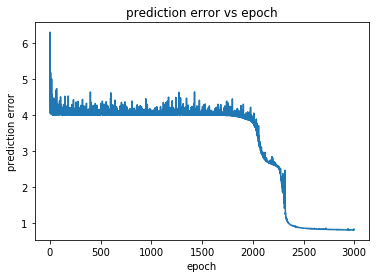

Final predictions : is it even?

[0 0 0 0] 0.034000689397 True
[0 0 0 1] 0.970422612396 False
[0 0 1 0] 0.971036408151 False
[0 0 1 1] 0.242494123022 True
[0 1 0 0] 0.971076564941 False
[0 1 0 1] 0.0277116722617 True
[0 1 1 0] 0.0279195546925 True
[0 1 1 1] 0.97433664121 False
[1 0 0 0] 0.971382448002 False
[1 0 0 1] 0.242507683477 True
[1 0 1 0] 0.242610865262 True
[1 0 1 1] 0.234888931809 True
[1 1 0 0] 0.0277838889728 True
[1 1 0 1] 0.974631430082 False
[1 1 1 0] 0.975161999127 False
[1 1 1 1] 0.243595696666 True
weights are: 
 (1st line are the biases for the layer)
 [array([[-3.3849764 , -2.15776822,  2.70453514,  6.46565081],
       [-5.52860287, -1.4178881 , -6.63184703, -5.81075982],
       [ 5.53489319, -0.8745304 ,  7.02224767,  5.96609816],
       [-5.52253863, -1.03766761, -6.63871448, -5.81948515],
       [-5.52483492, -1.19743626, -6.62327136, -5.83021933]]), array([[ -1.18125633],
       [  8.70929221],
       [  0.07476612],
       [-10.56552939],
       [  7.45592656]]

In [6]:
nn._fit(data, labels, learning_rate=0.2)

### Below is a step by step explanation of the `nn.fit`

In [ ]:
# add the bias unit to the input layer for all the examples ; (m,N) -> (m,N+1)
ones = np.ones((1, data.shape[0])) # 1,m
data = np.concatenate((ones.T, data), axis=1) # m,1 concat m,N -> m,N+1
        
# keep track of prediction error in the plot prediction error, epochs) 
er = []
# reshape the labels (m,) -> m,1 
m = labels.shape[0]
labels = labels.reshape(m, 1)

In [ ]:
data

In [ ]:
labels

In [ ]:
epochs = 5000
for epoch in range(epochs):
    if epoch % 1000 == 0:
        print ('epoch is {}'.format(epoch))
            
    # create 100 samples for the epoch 
    sample = np.random.randint(data.shape[0], size=100) # (1,100) array with int's from 0..15
            
    # forward
    input_ = data[sample]
    a = nn._forward(input_)
            
    # backprop
    target = labels[sample]
    nn._backprop(a, target, learning_rate=0.2)
            
    # keep track of the error for the plot 
    err = 0
    for i in range(original_data.shape[0]):
        err += np.square(nn.predict_single_data(original_data[i]) - labels[i])
    er.append(err)

In [ ]:
# plot prediction error vs epoch
x_axis = [i for i in range(epochs)]
y_axis = [er[j] for j in range(epochs)]
fig, ax = plt.subplots()
ax.plot(x_axis, y_axis)
ax.set(xlabel='epoch', 
       ylabel='prediction error', 
       title='prediction error vs epoch')
plt.show()